# 연습문제 1. VariationalAutoEncoder 구현하기

입력 : 이미지 A
출력 : 이미지 A

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

from torchvision.utils import save_image
import os

import matplotlib.pyplot as plt
from matplotlib import cm 
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

Using Device: cuda


In [2]:
epochs = 50
batch_size = 256
learning_rate = 0.01
hidden_size = 10

In [3]:
# torchvision.datasets.FGVCAircraft
dataset = datasets.FashionMNIST(root = './data/', train = True, download = True, transform = transforms.ToTensor())
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = datasets.FashionMNIST(root = './data/', train = False, download = True, transform = transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = 5, shuffle = True, num_workers = 2)

In [4]:
labels_num = dataset.targets.numpy()
labels = [class_names[i] for i in labels_num]

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, hidden_size)
        self.fc22 = nn.Linear(500, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
model = VAE().to(device)
model.train()

reconstruction_function = nn.BCELoss(size_average=False)

# --- defines the loss function --- #
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\ABR\anaconda3\envs\ispin\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [7]:
loss_list = []

for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, label) in enumerate(data_loader):
        # x = add_noise(x)  # 입력에 노이즈 더하기
        x = x.view(-1, 28*28).to(device)
        y = x.view(-1, 28*28).to(device) 
        label = label.to(device)
        recon_data, mu, logvar = model(x)
        loss = loss_function(recon_data, x, mu, logvar)
        loss_value += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch :  1 , Loss :  16601973.697265625
Epoch :  2 , Loss :  14843129.736328125
Epoch :  3 , Loss :  14581495.97265625
Epoch :  4 , Loss :  14425414.013671875
Epoch :  5 , Loss :  14325164.81640625
Epoch :  6 , Loss :  14267520.408203125
Epoch :  7 , Loss :  14226716.978515625
Epoch :  8 , Loss :  14190631.71875
Epoch :  9 , Loss :  14176999.947265625
Epoch :  10 , Loss :  14157833.796875
Epoch :  11 , Loss :  14125056.337890625
Epoch :  12 , Loss :  14123545.103515625
Epoch :  13 , Loss :  14108635.99609375
Epoch :  14 , Loss :  14117652.0859375
Epoch :  15 , Loss :  14097710.009765625
Epoch :  16 , Loss :  14091215.47265625
Epoch :  17 , Loss :  14089746.3359375
Epoch :  18 , Loss :  14075253.61328125
Epoch :  19 , Loss :  14074716.064453125
Epoch :  20 , Loss :  14069249.916015625
Epoch :  21 , Loss :  14070444.02734375
Epoch :  22 , Loss :  14064048.24609375
Epoch :  23 , Loss :  14077351.294921875
Epoch :  24 , Loss :  14048952.86328125
Epoch :  25 , Loss :  14052648.2890625
Epoch

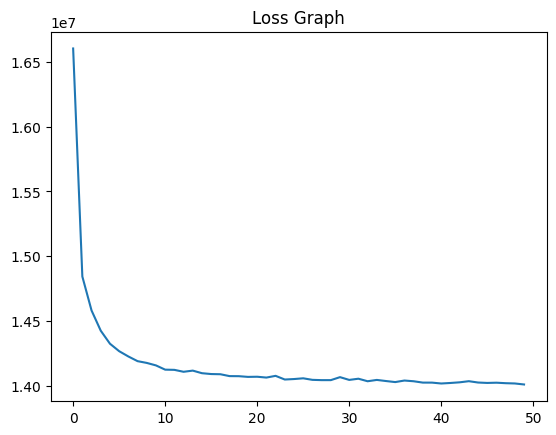

In [8]:
plt.title('Loss Graph')
plt.plot(loss_list)

In [14]:
torch.save(model ,'VAE.pth')

In [11]:
sample_image = dataset.data[:5].view(-1, 28*28)
sample_image = sample_image.type(torch.FloatTensor)/255.
sample_label = dataset.targets[:5]

with torch.no_grad():
    model.eval()
    test_image = sample_image.to(device)
    output, mu, logvar = model(test_image)

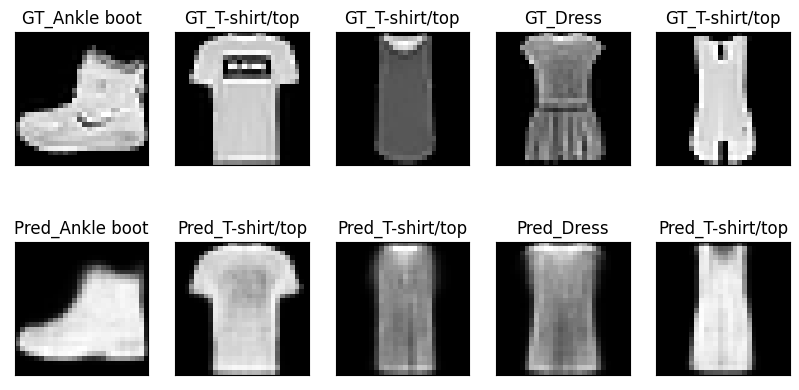

In [12]:
f, a = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):
    img = np.reshape(sample_image.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
    a[0][i].set_title('GT_'+class_names[sample_label[i]])

for i in range(5):
    img = np.reshape(output.to("cpu").data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
    a[1][i].set_title('Pred_'+class_names[sample_label[i]])
plt.show()